In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import median_abs_deviation, rankdata
from collections import defaultdict 
from joblib import Parallel, delayed

from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics 



sns.set_theme(rc={'figure.figsize':(18,6)}, style="white")
os.chdir('/Users/zagidull/Documents/gerosense/presymptomatic_covid_detection_algo/')

In [2]:
def readDF(patient_name: str, mypath: str='/Users/zagidull/Documents/gerosense/presymptomatic_covid_detection_algo/data_covidwearables/') -> pd.DataFrame:
    filename_hr = mypath+patient_name+'_hr.csv'
    filename_step = mypath+patient_name+'_steps.csv'
    #filename_sleep = mypath+patient_name+'_sleep.csv'

    df_hr = pd.read_csv(filename_hr, sep=',', header=0, index_col='datetime', parse_dates=True, usecols=['datetime', 'heartrate']) # would be good to set a format here format='%Y-%m-%d %H:%M:%S'
    df_hr = df_hr.loc[~df_hr.index.duplicated(keep='first')]
    
    df_step = pd.read_csv(filename_step, sep=',', header=0, index_col='datetime', parse_dates=True, usecols=['datetime', 'steps'])
    df_step = df_step.loc[~df_step.index.duplicated(keep='first')]

    #df_sleep = pd.read_csv(filename_sleep, sep=',', header=0, index_col='datetime', parse_dates=True, usecols=['datetime','stage_duration', 'stage'])
    #df_sleep = df_sleep.loc[~df_sleep.index.duplicated(keep='first')]
    
    #df_hr = df_hr.resample(rule='1T')[['heartrate']].mean() # change to 1min resolution to match with step counts

    #df = pd.merge(df_hr, df_step, left_index=True, right_index=True)
    return df_hr, df_step #, df_sleep

In [3]:
def featurize(df_hr, df_step, robust=False, d_rhr=None, d_dev=None, drop_original=True):
    '''
    * featurize by calculating z-scores using hourly RHR 
        if drop_original=True, remove original steps and heartrate columns, leaving only new features
    * preprocess data resampling to hourly resolution
    * calculate HROS (hr over steps) as HR / (steps+1). So this maps high HR and no steps (sick people) to high values, and active people who walk (==not sick) to low values
        by log10 HROS, we make it more normal-like
    * when robust=True, use robust statistics (median vs mean, mad vs std)
        to get robust z-scores on the same scale as normal z-scores, mad is scaled by multiplying by 1.486something
    * if d_rhr=None, calculate resting heart rate de novo, 
        else update provided dicts (relevant when train period does not have measurements to create hourly RHR scores)

    * returns Union(featurized_df, dict1 with hours as keys and RHR as values, dict2 with hours as keys and deviation of RHR as values)
    '''
    
    def makeRHR(temp: pd.DataFrame, robust: bool):
        '''
        robust vs normal statistics (see above)
        for measurement to be applicable for RHR calculation if over past 10 mins sum_steps=0. In paper they use rolling mean of last 12 values

        '''
        temp = temp.loc[temp.steps==0]
        d_rhr = defaultdict(list)
        d_dev = defaultdict(list)
        if robust:
            for idx,x in enumerate(temp.groupby(temp.index.hour).median()['heartrate']):
                d_rhr[idx].append(x)
            for idx,x in enumerate(temp.groupby(temp.index.hour)['heartrate'].apply(lambda x: median_abs_deviation(x, scale='normal', nan_policy='omit'))):
                d_dev[idx].append(x)
        else:
            for idx,x in enumerate(temp.groupby(temp.index.hour).mean()['heartrate']):
                d_rhr[idx].append(x)
            for idx,x in enumerate(temp.groupby(temp.index.hour)['heartrate'].apply(lambda x: np.nanstd(x))):
                d_dev[idx].append(x)
        return d_rhr, d_dev

    if robust:
        rhr_hr = df_hr.resample('1T').median() # for rhr
        hourly_hr = df_hr.resample('60T').median() 
    else:
        rhr_hr = df_hr.resample('1T').mean() # for rhr
        hourly_hr = df_hr.resample('60T').mean()
    
    # get RHR
    rhr_steps = df_step.rolling(10).sum() 
    rhr = pd.merge(rhr_hr, rhr_steps, left_index=True, right_index=True, how="outer") 
    if not d_rhr==None: # when we update hourly RHR
        d_rhr_new, d_dev_new = makeRHR(rhr, robust=robust)
        for k,v in d_rhr_new.items():
            d_rhr[k].append(v[0])
        for k,v in d_dev_new.items():
            d_dev[k].append(v[0])
    else: # the very first time
        d_rhr, d_dev = makeRHR(rhr, robust=robust)
    
    # featurize data  
    hourly_steps = df_step.resample('60T').sum()
    df = pd.merge(hourly_hr, hourly_steps, left_index=True, right_index=True, how="outer")
    df = df.loc[~df.isna().any(axis=1)]
    val1 = (df['heartrate'] - np.asarray([d_rhr[x][-1] for x in df.index.hour]))/np.asarray([d_dev[x][-1] for x in df.index.hour]) # zscore
    val2 = np.log10(df['heartrate']/(df['steps']+1)) # hros
    df.insert(loc=df.shape[1], column='z', value=val1)
    df.insert(loc=df.shape[1], column='hros', value=val2)
    
    if drop_original:
        df.drop(columns=['heartrate','steps'], inplace=True)
    #out = pd.concat([df.heartrate, val1, val2], axis=1)
    #out.columns = ['heartrate','z','hros']
    #out.loc[:,:] = StandardScaler().fit_transform(out)
    
    return df, d_rhr, d_dev

In [4]:
def featurize_test(df_hr, df_step, d_rhr, d_dev, robust=False, drop_original=True):
    '''
    * returns only featurized df, unlike featurize, which also returns dict with RHR and RHR_dev
    '''
    hourly_steps = df_step.resample('60T').sum()
    if robust:
        hourly_hr = df_hr.resample('60T').median() 
    else:
        hourly_hr = df_hr.resample('60T').mean()
    
    # featurize data  
    
    df = pd.merge(hourly_hr, hourly_steps, left_index=True, right_index=True, how="outer")
    df = df.loc[~df.isna().any(axis=1)]
    val1 = (df['heartrate'] - np.asarray([d_rhr[x][-1] for x in df.index.hour]))/np.asarray([d_dev[x][-1] for x in df.index.hour]) # zscore
    val2 = np.log10(df['heartrate']/(df['steps']+1)) # hros
    #val3 = df.groupby(df.index.date
    df.insert(loc=df.shape[1], column='z', value=val1)
    df.insert(loc=df.shape[1], column='hros', value=val2)

    if drop_original:
        df.drop(columns=['heartrate','steps'], inplace=True)

    return df

In [5]:
patient_name='AFPB8J2'
df_hr, df_step = readDF(patient_name=patient_name) # read just one
dates = np.unique((df_hr.index.date)).tolist()

In [6]:
# train data

len_train = 17
start = list(range(0,len_train))[0]
end = list(range(0,len_train))[-1]

hr_train = df_hr.loc[dates[start]: dates[end]]  # makeTrain(df_hr, delta=delta)
step_train = df_step.loc[dates[start]: dates[end]]

df, _, _ = featurize(hr_train, step_train, robust=True, drop_original=False)

In [7]:
df

,heartrate,steps,z,hros
datetime,,,,
2026-06-22 00:00:00,80.0,669,2.697959,-0.922985
2026-06-22 01:00:00,73.0,0,0.674490,1.863323
2026-06-22 02:00:00,73.0,0,1.734402,1.863323
2026-06-22 03:00:00,65.0,79,0.224830,-0.090177
2026-06-22 04:00:00,62.0,4,0.224830,1.093422
...,...,...,...,...
2026-07-07 19:00:00,79.0,395,0.749433,-0.700068
2026-07-07 20:00:00,84.0,1290,2.135884,-1.186647
2026-07-07 21:00:00,69.0,179,-0.539592,-0.416423


### EDA

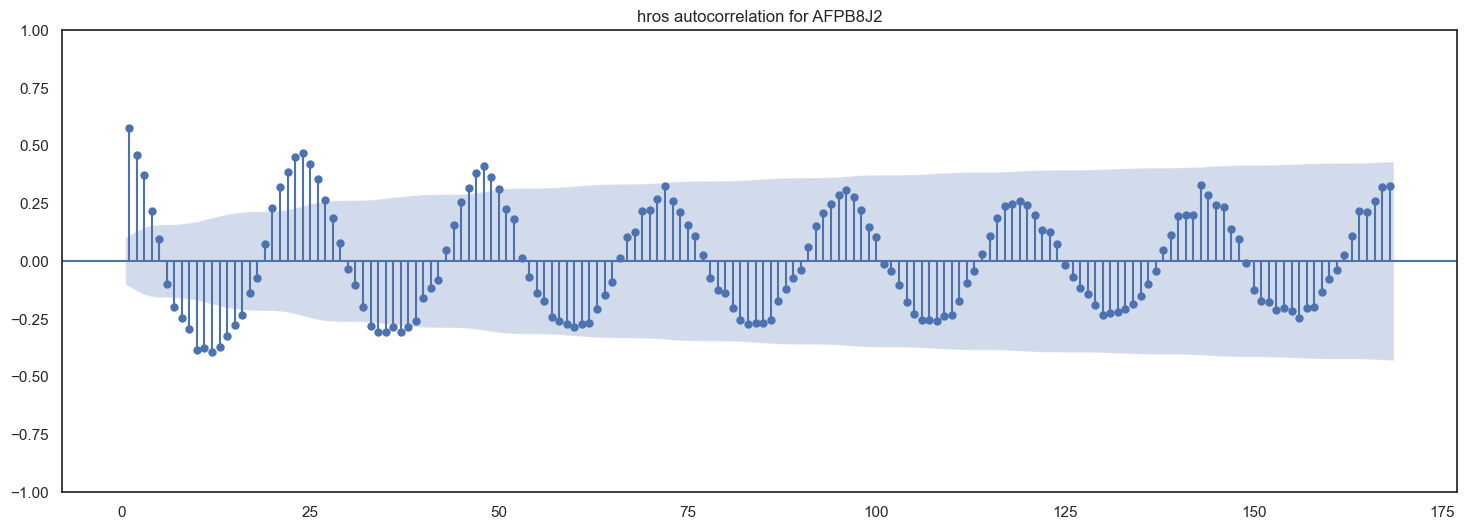

In [8]:
col_name = 'hros'

fig = tsaplots.plot_acf(df[col_name], lags=168, zero=False, title=f'{col_name} autocorrelation for {patient_name}') # there is some periodicity in things like HROS/steps when looking at 24 hr intervals (obviously)

In [9]:
# looks like simple seasonal decompostion is not making sense

decomp_stats = pd.DataFrame(columns=['feature','period','mean','std']) #set a dataframe to store the calculation results\
for col in df.columns:
    for i in range(1, 24*7+1): #specify a range of period multipliers
        stl_decomp = seasonal_decompose(df[col],model='additive', period = i)
        decomp_stats = pd.concat([decomp_stats, 
                                  pd.DataFrame({'feature':[col], 'period':[i], 'mean':[stl_decomp.resid.mean()], 'std':[stl_decomp.resid.std()]})]
                                )
        decomp_stats.reset_index(drop=True,inplace=True)

decomp_stats.groupby('feature').apply(lambda x: x.iloc[np.argmin(x['std'])] ) 

,feature,period,mean,std
feature,,,,
heartrate,heartrate,1,0.0,0.0
hros,hros,1,0.0,0.0
steps,steps,1,0.0,0.0
z,z,1,0.0,0.0


In [10]:
# but using STIL we see some weekly trends. Maybe

decomp_stats = pd.DataFrame(columns=['feature','period','r_mean','r_std'])
for col in df.columns:
    for i in range(1, 8): 
        stl_decomp = STL(df[col], period = 24*i).fit()
        decomp_stats = pd.concat([decomp_stats, 
                                  pd.DataFrame({'feature':[col], 'period':[24*i], 'r_mean':[stl_decomp.resid.mean()], 'r_std':[stl_decomp.resid.std()]})]
                                )
        decomp_stats.reset_index(drop=True,inplace=True)

decomp_stats.groupby('feature').apply(lambda x: x.iloc[np.argmin(x['r_std'])] ) 

,feature,period,r_mean,r_std
feature,,,,
heartrate,heartrate,168,0.060118,2.062161
hros,hros,168,-0.004312,0.218583
steps,steps,168,-1.601568,97.645186
z,z,168,0.011611,0.443278


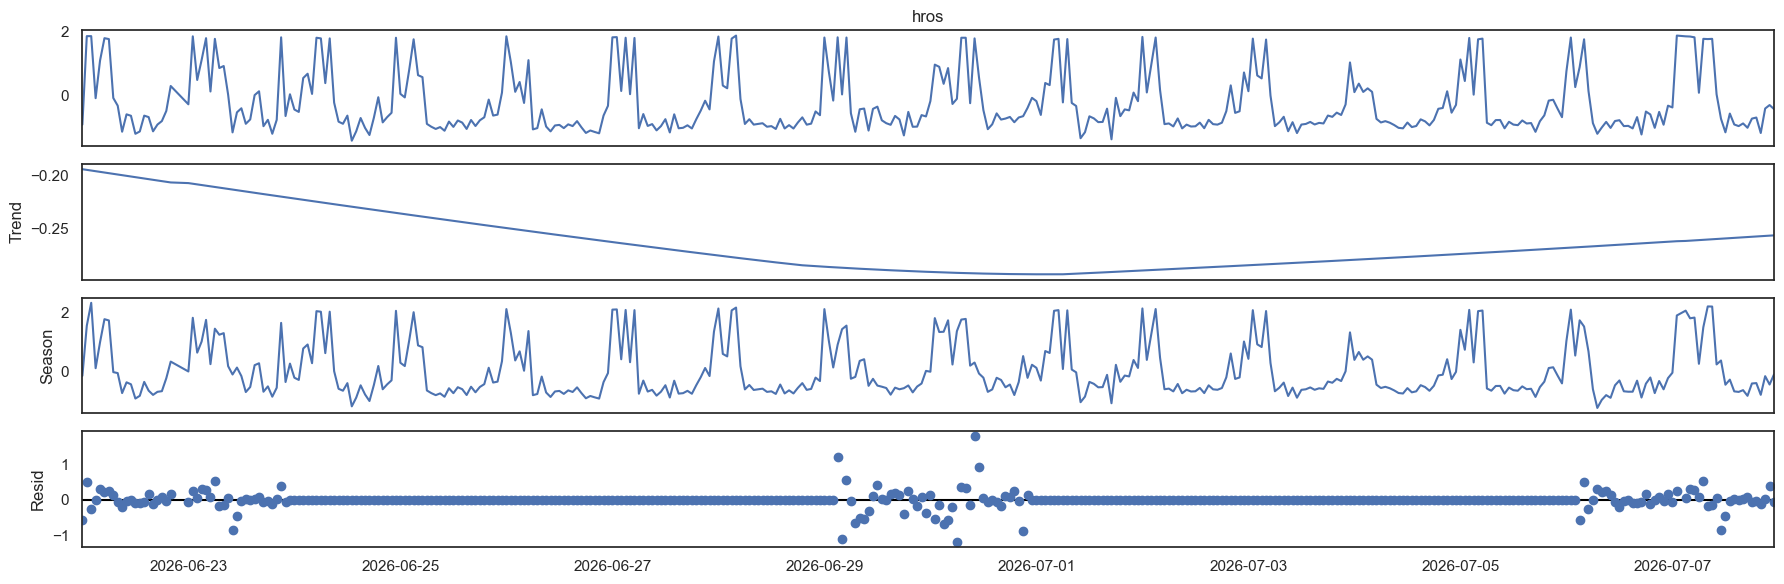

In [11]:
# or people do jack on the weekends? 

decomp_steps = STL(df['hros'], period=168).fit()
fig = decomp_steps.plot()

### ML model

In [16]:
def runPrediction(df_hr: pd.DataFrame, df_step: pd.DataFrame, contamination_EE: float=0.01, contamination_IF: float=0.01625, robust: bool=False, drop_original: bool=False, len_train:int =14, seed: int=0) -> pd.DataFrame:
    '''
    * contamination_EE/_IF parameters are the proportion of outliers to be detected in a dataset
    * len_train is how many days are used for model training. It is then used as a sliding window
    * robust is using robust statistics, ie median instead of mean, (scaled) mad instead of std, etc
    * drop_original removes 'steps' and 'heartrate' columns, leaving only z-score and hros = log10(heartrate/(steps+1))

    returns y_predictions dataframe with two columns (one for Elliptical Envelope, anotehr for Isolation Forest) and num_rows = num_total_hours - len_train*24
    '''
    ############################################################
    # get train dates as (first) len_train days from the dataset
    ############################################################
    dates = np.unique((df_hr.index.date)).tolist()
    start = list(range(0,len_train))[0]
    end = list(range(0,len_train))[-1]
    
    #############################
    # prepare train and test data
    #############################
    ## train 
    hr_train = df_hr.loc[dates[start]: dates[end]]
    step_train = df_step.loc[dates[start]: dates[end]]
    
    ## test
    hr_test = df_hr.loc[dates[end]: dates[end+1]] 
    step_test = df_step.loc[dates[end]: dates[end+1]]
    
    ## featurize train and test
    df_train, d_rhr, d_dev = featurize(hr_train, step_train, robust=robust, drop_original=drop_original)
    df_test = featurize_test(hr_test, step_test, d_rhr=d_rhr, d_dev=d_dev, robust=robust, drop_original=drop_original)
    
    ## scale to zeromean onevar
    df_train.loc[:,:] = StandardScaler().fit_transform(df_train) # Yeah scaling z-scores is funny, but oh well
    df_test.loc[:,:] = StandardScaler().fit_transform(df_test)

    #################
    # predict on test
    #################
    ## models
    cov = EllipticEnvelope(random_state=seed, contamination=contamination_EE).fit(df_train) 
    forest = IsolationForest(contamination=contamination_IF, n_jobs=1).fit(df_train.values)
    #svm = OneClassSVM(kernel='linear').fit(df_train.values)
    ## predictions
    data=np.stack([cov.predict(df_test), forest.predict(df_test.values)], axis=1)
    y_pred = pd.DataFrame(data=data, index=df_test.index, columns=['prediction_EE', 'prediction_IF'])

    ####################################################################
    # for every *hour* after initial train period, predict anomalies
    # for every *day* after initial train period, retrain baseline model
    ####################################################################
    for idx,d in enumerate(dates[len_train:], start=1):
        if idx+len_train+1 != len(dates):
            
            ## train
            hr_train =  df_hr.loc[(df_hr.index.date >= dates[idx]) & (df_hr.index.date < dates[idx+len_train])]
            step_train = df_step.loc[(df_step.index.date >= dates[idx]) & (df_step.index.date < dates[idx+len_train])]
            df_train, d_rhr_new, d_dev_new = featurize(hr_train, step_train, robust=robust, d_rhr=d_rhr, d_dev=d_dev, drop_original=drop_original)
            
            ## update RHR from new train
            ## we use z-scores in prediction and sometimes there are no available zscores for a given hour in a given train period. 
            ## then get last available z-score from that hour
            for k,v in d_rhr_new.items():
                d_rhr[k].append(v[0])
            for k,v in d_dev_new.items():
                d_dev[k].append(v[0])
            
            ## test 
            hr_test = df_hr.loc[(df_hr.index.date >= dates[idx+len_train]) & (df_hr.index.date < dates[idx+len_train+1])]
            step_test = df_step.loc[(df_step.index.date >= dates[idx+len_train]) & (df_step.index.date < dates[idx+len_train+1])]
            if len(hr_test)<1 or len(step_test)<1:
                break
            df_test = featurize_test(hr_test, step_test, d_rhr, d_dev, robust=robust, drop_original=drop_original)

            ## scale to zeromean onevar
            df_train.loc[:,:] = StandardScaler().fit_transform(df_train)
            df_test.loc[:,:] = StandardScaler().fit_transform(df_test)
            
            ## predict
            cov = EllipticEnvelope(random_state=seed, contamination=contamination_EE).fit(df_train)
            forest = IsolationForest(contamination=contamination_IF, n_jobs=1).fit(df_train.values)
            #svm = OneClassSVM().fit(df_train.values)
            data = np.stack([cov.predict(df_test), forest.predict(df_test.values)], axis=1)
            y_pred = pd.concat([y_pred, pd.DataFrame(data=data, index=df_test.index, columns=['prediction_EE', 'prediction_IF'])], axis=0)
        else:
            break
    return y_pred

In [17]:
def processYpred(y_pred: pd.DataFrame, ground_truths = None, cutoff_hour: int=9, method: str='average'):
    '''
    for a given dataframe of predictions, filter those earlier than cutoff_hour (in paper they filtered anything outside midnight:6am)
    then get daily mean prediction
    then check in which days daily score is below 1 (ie any anomalies are predicted)
    sort those, rank those
    get top 3 ranked (can be more than 3 params combinations, since scanranks gives identical ranks if scores are equal, unless method='ordinal' is used)
    calculate distance between ground_truths and those top-ranked predictions, where ground_truths are 1) date of COVID symptoms onset and 2) date of diagnosis
    our final score is a weighted average of those distances, where weights are 1/rank. 
    
    >>> This score doesnot penalize enough for total number of predictions, ie a model that predicts every day to be anomalous would win over more conservative model
    >>> we somehow make sure that doesnt get out of hand by setting contamination parameters in range 0.001 to 0.05, but still
    >>>>>>>> would be better to combine with some version of Fbeta-score, eg F1 see "An Evaluation of Change Point Detection Algorithms", van deb Burg & Williams 2022

    * returns either just filtered y_pred, or if given ground truths, mean distance
    
    '''
    filtered = y_pred.groupby(y_pred.index.hour).filter( lambda x: np.all(x.index.hour < cutoff_hour) )
    filtered = filtered.groupby(filtered.index.date).agg('mean')
    filtered = filtered.iloc[np.argsort(filtered.sum(axis=1))]
    filtered = filtered.iloc[np.where( filtered.sum(axis=1) < 2 )[0]]
    filtered['rank'] = rankdata(filtered.sum(axis=1), method=method)

    out = []
    if len(filtered)!=0:
        if ground_truths is not None:
            for ts in ground_truths:
                filtered = filtered.loc[filtered['rank']<4]
                out.append( 
                    np.average(
                        abs(pd.to_datetime(filtered.index) - ts).to_numpy().tolist(), 
                        weights = 1/filtered['rank'].values
                    ).astype('timedelta64[ns]').astype('timedelta64[h]') 
                )
            return np.mean(out).astype('float')
        else:
            return filtered
    else:
        return np.nan

In [14]:
# covid patients from SuppTable Fig2A
# A0NVTRV gives mean of empty slice 
covid_patients = ['AFPB8J2', 'APGIB2T', 'AQC0L71', 'A0NVTRV', 'A4G0044', 'A3OU183', 'AS2MVDL', 'AJWW3IY', 'AAXAA7Z',
                  'AHYIJDV', 'AV2GF3B', 'ASFODQR', 'ATHKM6V', 'A0VFT1N', 'AYWIEKR', 'AYEFCWQ',
                  'AA2KP1S', 'AJMQUVV', 'AMV7EQF', 'A1ZJ41O']

covid_symptom_dates = [ '2026-07-14 00:00:00', '2023-05-22 00:00:00', '2028-06-17 00:00:00', '2023-12-06 00:00:00', '2027-03-04 00:00:00', '2024-11-23 00:00:00',
                       '2025-03-02 00:00:00', '2024-08-09 00:00:00', '2023-03-30 00:00:00', '2025-01-16 00:00:00', '2026-02-12 00:00:00', '2024-08-14 00:00:00',
                       '2024-03-06 00:00:00', '2023-10-13 00:00:00', '2023-04-07 00:00:00', '2025-07-07 00:00:00', '2025-01-06 00:00:00', '2024-09-05 00:00:00',
                       '2027-06-09 00:00:00', '2027-08-06 00:00:00']

covid_dx_dates = ['2026-07-17 00:00:00', '2023-05-28 00:00:00', '2028-06-19 00:00:00', '2023-12-11 00:00:00', '2027-03-08 00:00:00', '2024-11-27 00:00:00',
                  '2025-03-05 00:00:00', '2024-08-10 00:00:00', '2023-04-13 00:00:00', '2025-01-22 00:00:00', '2026-02-18 00:00:00', '2024-08-15 00:00:00',
                  '2024-03-06 00:00:00', '2023-10-16 00:00:00', '2023-04-09 00:00:00', '2025-07-08 00:00:00', '2025-01-11 00:00:00', '2024-09-06 00:00:00',
                  '2027-06-11 00:00:00', '2027-08-10 00:00:00']

In [15]:
er_patients = []
n_jobs = 10
cutoff_hour = 7
columns = ['patient_name', 'contamination_EE', 'contamination_IF', 'robust', 'distance']
df = pd.DataFrame(columns=columns)

for patient_name, symptom_date, dx_date in zip(covid_patients, covid_symptom_dates, covid_dx_dates):
    
    # set parameters to test
    params = []
    df_hr, df_step = readDF(patient_name=patient_name)
    for contamination_EE in np.linspace(0.001, 0.05, 5):
        for contamination_IF in np.linspace(0.001, 0.05, 5):
            for robust in [True, False]:
                params.append([df_hr, df_step, contamination_EE, contamination_IF, robust])
    try:
        # predictions
        out = Parallel(n_jobs=n_jobs)( delayed(runPrediction)( df_hr, df_step, contamination_EE, contamination_IF, robust) for df_hr, df_step, contamination_EE, contamination_IF, robust in params) 
    
        # process results
        ground_truths=[pd.Timestamp(symptom_date), pd.Timestamp(dx_date)]
        deltas = [ processYpred(x, cutoff_hour=cutoff_hour, ground_truths=ground_truths, method='min') for x in out] 
        
        # results collection
        data = []
        for delta, (_, _, contamination_EE, contamination_IF, robust) in zip(deltas, params):
            data.append([patient_name, contamination_EE, contamination_IF, robust, delta])
        results = pd.DataFrame(data=data, columns=columns)
        results = results.iloc[np.argsort( results['distance'].values)[:5]]
        df = pd.concat([df, results])
        df.reset_index(drop=True, inplace=True)
        print(patient_name)
    except:
        er_patients.append(patient_name)
        print(f'patient err {patient_name}')
        continue
        

AFPB8J2
APGIB2T
AQC0L71


/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: Run

patient err A0NVTRV
A4G0044
A3OU183
AS2MVDL
AJWW3IY
AAXAA7Z
AHYIJDV
patient err AV2GF3B
patient err ASFODQR
ATHKM6V
A0VFT1N
AYWIEKR
AYEFCWQ
AA2KP1S
AJMQUVV
AMV7EQF
A1ZJ41O


In [22]:
# for some patients things worked OK, like A3OU183=48, AA2KP1S=60, ATHKM6V=52. so top3 ranked prediction were within ~2 days of the ground truth dates
# for others, wellllll look at A1ZJ41O with 648 - ie we are off by circa a month...

df.groupby('patient_name').apply(lambda x: x.iloc[np.argmin(x['distance'])] ) 

,patient_name,contamination_EE,contamination_IF,robust,distance
patient_name,,,,,
A0VFT1N,A0VFT1N,0.00100,0.05000,True,372.0
A1ZJ41O,A1ZJ41O,0.02550,0.01325,False,648.0
A3OU183,A3OU183,0.05000,0.00100,False,48.0
A4G0044,A4G0044,0.05000,0.00100,True,422.0
AA2KP1S,AA2KP1S,0.01325,0.01325,False,60.0
AAXAA7Z,AAXAA7Z,0.02550,0.02550,True,167.0
AFPB8J2,AFPB8J2,0.02550,0.05000,True,98.0
AHYIJDV,AHYIJDV,0.00100,0.05000,True,448.0
AJMQUVV,AJMQUVV,0.00100,0.00100,True,204.0


In [21]:
with pd.option_context('display.max_rows', None):
    print(df)

   patient_name  contamination_EE  contamination_IF robust  distance
0       AFPB8J2           0.02550           0.05000   True      98.0
1       AFPB8J2           0.02550           0.05000  False      99.0
2       AFPB8J2           0.01325           0.05000  False      99.0
3       AFPB8J2           0.01325           0.03775  False      99.0
4       AFPB8J2           0.00100           0.03775   True     101.0
5       APGIB2T           0.00100           0.00100   True     291.0
6       APGIB2T           0.00100           0.01325   True     291.0
7       APGIB2T           0.05000           0.03775  False     318.0
8       APGIB2T           0.05000           0.02550  False     318.0
9       APGIB2T           0.02550           0.01325  False     320.0
10      AQC0L71           0.00100           0.01325  False      72.0
11      AQC0L71           0.03775           0.03775  False      96.0
12      AQC0L71           0.02550           0.03775  False      96.0
13      AQC0L71           0.01325 